# SYSID - Atividade 06

Aluno: Pedro Henrique Cardoso Paulo<br>

Professor: Helon

## Objetivo

Nessa atividade vamos tentar aplicar os fundamentos da identificação contínua de sistemas. Devido a problemas com o Octave essa atividade será feita em Python, fazzendo uso das bibliotecas `scikitt-learn`, `control`, `scipy` e `numpy`

## Arquivos de suporte

Na pasta deste notebook poderão ser encontrados dois arquivos com funções e classes de suporte:

* <a href="./time_processing.py">time_processing.py</a>: pacote com função para reamostragem do sinal no tempo fazendo uso de interpolação
* <a href="./ContinuousDerivativePreprocessor.py">ContinuousDerivativePreprocessor.py</a>: tentativa de implementar, com a sitaxe sklearn um preprocessador de derivadas temporais

## Passo 0 - Importando bibliotecas

In [48]:
#Desabilitando warnings
#def warn(*args, **kwargs):
#    pass
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
#warnings.warn = warn

# Pacotes padrao
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import datetime

#sysidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.general_estimators.narx import NARX
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

#Pipeline
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.model_selection import RandomizedSearchCV

# Scores
from sklearn.metrics import r2_score

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [49]:
data = np.genfromtxt('../data/robot_arm.dat')
X1 = data[:,0].reshape(-1,1)
y = data[:,1].reshape(-1,1)

### 0.2 - Visualizando dados

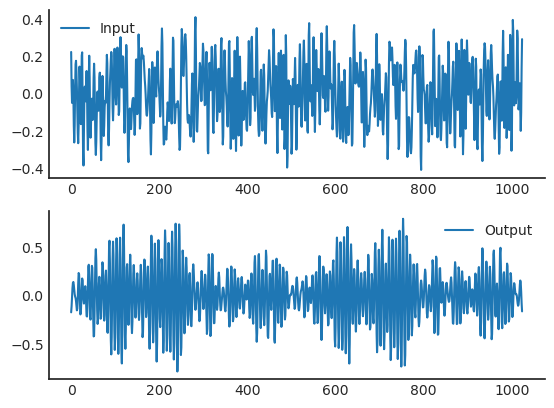

In [50]:
fig, ax = plt.subplots(2,1)
ax[0].plot(X1, label='Input')
ax[1].plot(y, label='Output')
ax[0].legend()
ax[1].legend()

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [51]:
p_train = 0.5 #50% treino

### 1.2 - Separando os conjuntos

In [52]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[n_train:,:]
y_te = y[n_train:,:]

In [53]:
print(
    X1_tr.shape,
    X1_te.shape
)

(512, 1) (512, 1)


## Passo 2 - Iniciando a construção do modelo ARMAX/NARMAX

Para essa atividade, vamos usar a biblioteca sysidentpy. Essa biblioteca guarda grandes similaridades com bibliotecas da área de machine learning, como `scikit-learn`, `tensorflow` e `pytorch`.

### 2.1 - Selecionando a função-base

In [54]:
basis_function = Polynomial(degree=1)

### 2.2 - Selecionando a arquitetura (sysidentpy)

In [55]:
na = 4
nb = 6
ne = 1
model_SYSID = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=na+nb+ne,
    model_type='NARMAX',
    #extended_least_squares=True,
)

### 2.3 - Selecionando arquitetura (ARIMA)

In [56]:
na = 4
nb = 6
ne = 1
model_STATS = ARIMA(
    endog=y_tr,
    exog=X1_tr,
    order=(na, nb, ne)
)

## Passo 3 - Realizando ajuste inicial

### 3.1 - Performando o ajuste

In [57]:
model_SYSID.fit(X=X1_tr, y=y_tr)
model_STATS = model_STATS.fit()

In [58]:
r = pd.DataFrame(
    results(
        model_SYSID.final_model, model_SYSID.theta, model_SYSID.err,
        model_SYSID.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-4),-1.0060E+00,8.82401672E-01
1,x1(k-2),1.0650E+00,3.29600726E-02
2,y(k-1),3.2473E+00,1.02592690E-02
3,y(k-2),-4.5883E+00,6.85312782E-02
4,y(k-3),3.2503E+00,5.50065803E-03
5,x1(k-6),2.2748E-01,8.12464352E-05
6,x1(k-1),-2.9875E-01,1.93346008E-05
7,x1(k-5),-9.3904E-01,1.18151736E-05
8,x1(k-3),-1.7335E+00,3.08671003E-05
9,x1(k-4),1.6766E+00,1.80355117E-04


In [59]:
print(model_STATS.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  512
Model:                 ARIMA(4, 6, 1)   Log Likelihood                1605.681
Date:                Sat, 01 Oct 2022   AIC                          -3197.362
Time:                        10:34:25   BIC                          -3167.776
Sample:                             0   HQIC                         -3185.758
                                - 512                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0240      0.004     -5.566      0.000      -0.033      -0.016
ar.L1          0.5148      0.107      4.832      0.000       0.306       0.724
ar.L2         -0.6550      0.195     -3.354      0.0

## Passo 4 - Comparando os resultados

### 4.1 - Calculando predição OSA

In [74]:
y_tr_pr_OSA_SYSID = model_SYSID.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA_SYSID = model_SYSID.predict(X=X1_te, y=y_te,steps_ahead=1)

y_tr_pr_OSA_STATS = model_STATS.predict(steps=512, endog=y_tr, exog=X1_tr)
y_te_pr_OSA_STATS = model_STATS.predict(steps=512, endog=y_tr, exog=X1_tr)

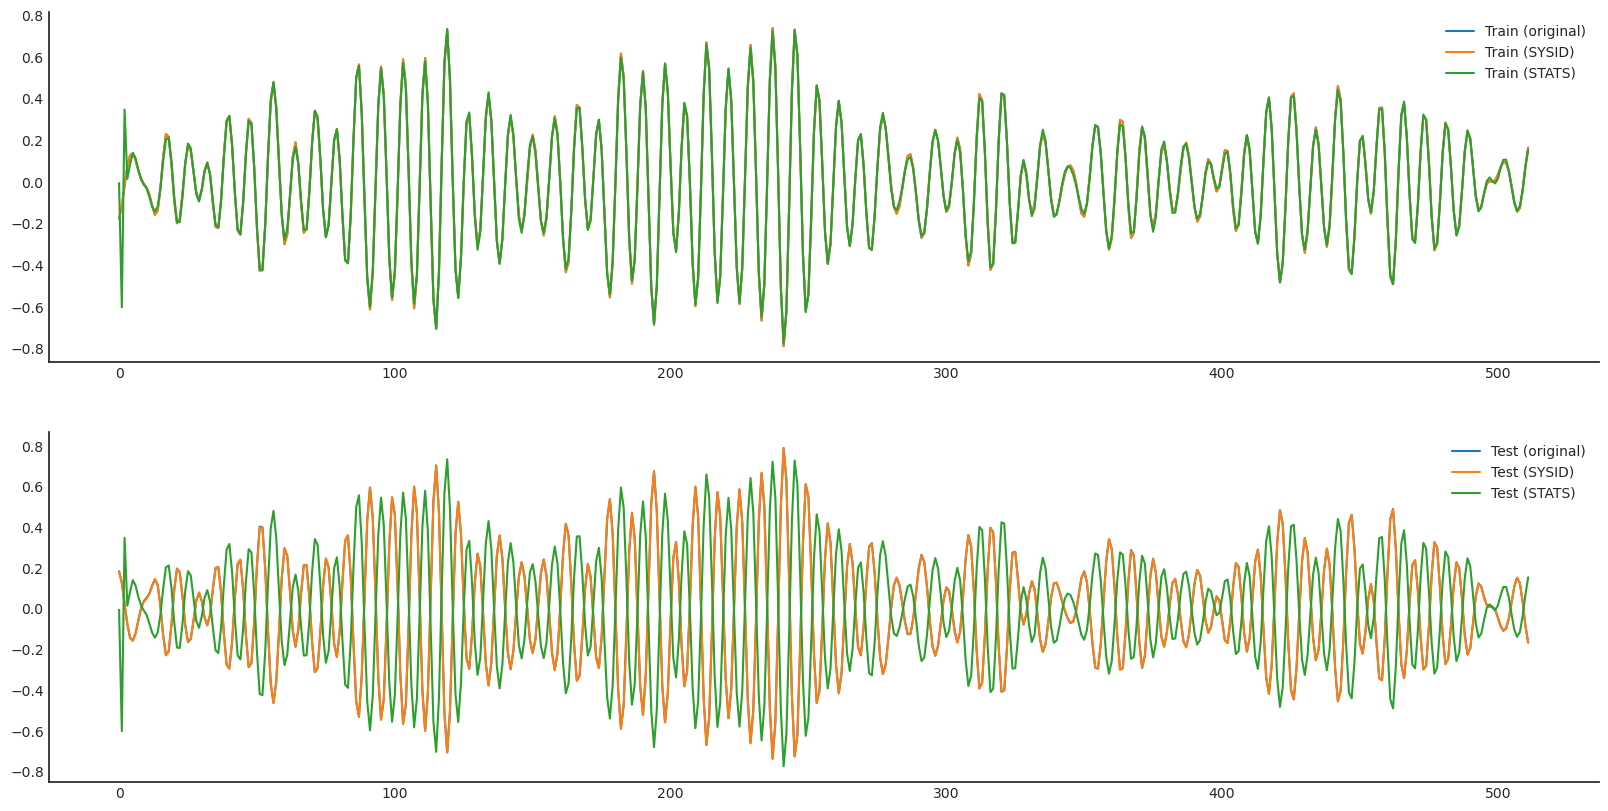

In [75]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_OSA_SYSID, label='Train (SYSID)')
ax[0].plot(y_tr_pr_OSA_STATS, label='Train (STATS)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_OSA_SYSID, label='Test (SYSID)')
ax[1].plot(y_te_pr_OSA_STATS, label='Test (STATS)')
ax[0].legend()
ax[1].legend()

In [77]:
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_OSA_SYSID))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_OSA_SYSID))

R2 score for OSA prediction (train) : 0.9999741789006141
R2 score for OSA prediction (test)  : 0.9999680680257568


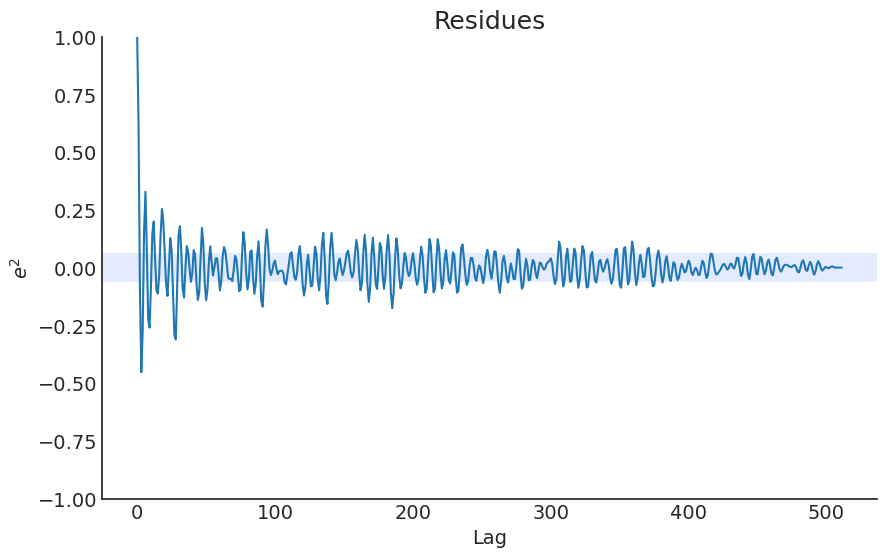

In [78]:
ee = compute_residues_autocorrelation(y_tr, y_tr_pr_OSA_SYSID)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")

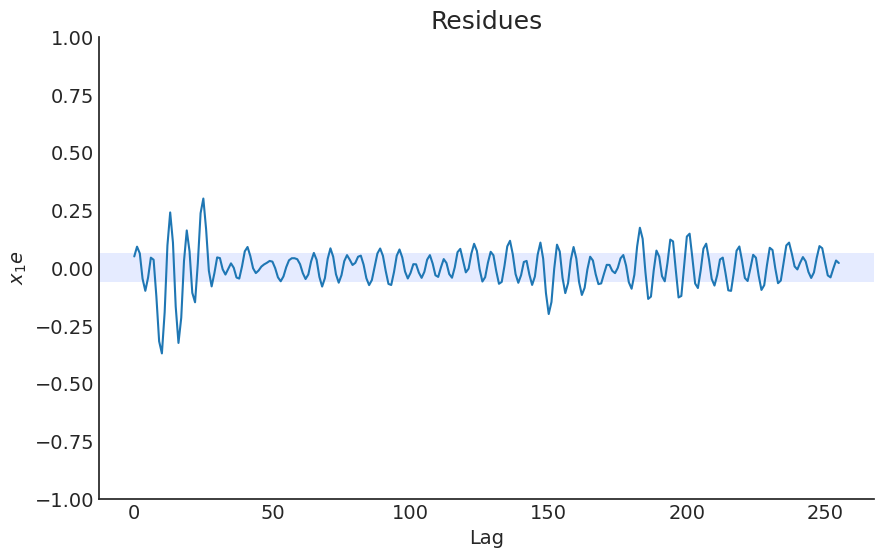

In [79]:
x1e = compute_cross_correlation(y_tr, y_tr_pr_OSA_SYSID, X1_tr)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

### 4.3 - Calculando predição FS

In [80]:
y_tr_pr_FS = model_SYSID.predict(X=X1_tr, y=y_tr,steps_ahead=None)
y_te_pr_FS = model_SYSID.predict(X=X1_te, y=y_te,steps_ahead=None)

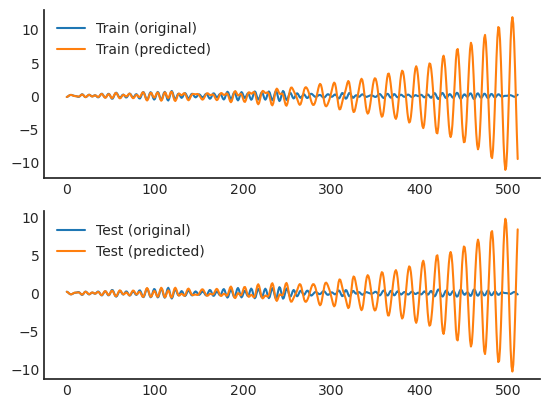

In [81]:
fig, ax = plt.subplots(2,1)
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_FS, label='Train (predicted)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_FS, label='Test (predicted)')
ax[0].legend()
ax[1].legend()

In [18]:
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_FS))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_FS))

R2 score for OSA prediction (train) : -107.45111246511944
R2 score for OSA prediction (test)  : -85.12925960766381


### 4.4 - Calculando predição 100 passos a frente

In [88]:
n_steps=100
y_tr_pr_FS = model_SYSID.predict(X=X1_tr, y=y_tr,steps_ahead=n_steps)
y_te_pr_FS = model_SYSID.predict(X=X1_te, y=y_te,steps_ahead=n_steps)

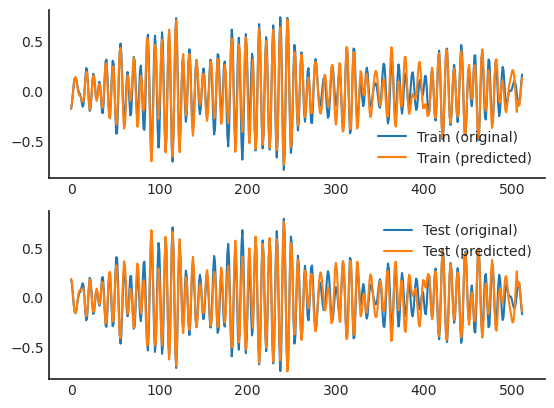

In [89]:
fig, ax = plt.subplots(2,1)
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_FS, label='Train (predicted)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_FS, label='Test (predicted)')
ax[0].legend()
ax[1].legend()

In [90]:
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_FS))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_FS))

R2 score for OSA prediction (train) : 0.8913686658166542
R2 score for OSA prediction (test)  : 0.8853782027780869


## Passo 5 - Tentando aplicar GridSearchCV no ARMAX

Infelizmente, a implementação do sysidentpy não permite seu uso em conjunto com as ferramentas de busca aleatória do scikit-learn, de modo que vamos fazer uma busca em grade por meuio de um loop explícito

### 4.1 - Definindo o range das variáveis

In [91]:
xlag_range = range(1,10)
ylag_range = range(1,10)
elag_range = range(1,10)

### 4.2 - Alocando estrutura para salvar os resultados

In [92]:
results_gsearch = {
    'xlag'        :[],
    'ylag'        :[],
    'elag'        :[],
    'R2_OSA_TRAIN':[],
    'R2_FS_TRAIN' :[],
    'R2_OSA_TEST' :[],
    'R2_FS_TEST'  :[],
}

### 4.3 - Executando o loop

In [93]:
n_iter = 0
iters_to_print = 100
for xlag in xlag_range:
    for ylag in ylag_range:
        for elag in elag_range:
            n_iter += 1
            if n_iter % iters_to_print == 0:
                print(f'Executing iteration: {n_iter}')
            model = FROLS(
                    order_selection=True,
                    ylag=ylag, xlag=xlag,elag=elag,
                    basis_function=basis_function,
                    n_info_values=100,
                    #n_terms=na+nb+ne,
                    model_type='NARMAX',
                    extended_least_squares=(elag > 1),
                        )
            
            model.fit(X=X1_tr, y=y_tr)

            y_tr_pr_OSA = model.predict(X=X1_tr, y=y_tr,steps_ahead=1)
            y_te_pr_OSA = model.predict(X=X1_te, y=y_te,steps_ahead=1)
            y_tr_pr_FS  = model.predict(X=X1_tr, y=y_tr,steps_ahead=None)
            y_te_pr_FS  = model.predict(X=X1_te, y=y_te,steps_ahead=None)

            results_gsearch['xlag'].append(xlag)
            results_gsearch['ylag'].append(ylag)
            results_gsearch['elag'].append(elag)

            results_gsearch['R2_OSA_TRAIN'].append(r2_score(y_tr,y_tr_pr_OSA))
            results_gsearch['R2_FS_TRAIN'].append(r2_score(y_tr,y_tr_pr_FS))
            results_gsearch['R2_OSA_TEST'].append(r2_score(y_tr,y_te_pr_OSA))
            results_gsearch['R2_FS_TEST'].append(r2_score(y_tr,y_te_pr_FS))

results_df = pd.DataFrame(results_gsearch)
            

Executing iteration: 100
Executing iteration: 200
Executing iteration: 300
Executing iteration: 400
Executing iteration: 500
Executing iteration: 600
Executing iteration: 700


In [94]:
results_df.sort_values(['R2_FS_TEST', 'R2_FS_TRAIN'], ascending=False).head(5)

,xlag,ylag,elag,R2_OSA_TRAIN,R2_FS_TRAIN,R2_OSA_TEST,R2_FS_TEST
62,1,7,9,0.999912,-0.342763,-2.930894,0.119654
63,1,8,1,0.999937,-0.293547,-2.930494,0.112228
54,1,7,1,0.999937,-0.278476,-2.930473,0.109498
45,1,6,1,0.999936,-0.283507,-2.930428,0.108569
72,1,9,1,0.999957,-0.142696,-2.930562,0.088320
